# Covid Data

Yet unpublished dataset containing covid data from David? and Meshal?. 

In [1]:
import pandas as pd
import scanpy as sc
import scipy
import anndata
import scirpy as ir
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
import seaborn as sb
sb.set_style('white')

# Single cell data preprocessing

Adapted from single cell preprocessing maren?

In [2]:
path_base = '../data/Covid/'
path_raw = path_base + 'Covid19_TAs_PBMCs.h5ad'
path_filtered = path_base + '02_covid_filtered_tcr.h5ad'
path_tcr_split = path_base + '03_covidcovidtrain_test_split.h5ad'
path_highlyvar = path_base + '04_covid_highly_var_5000.h5ad'

## Filtering

In [3]:
adata = sc.read_h5ad(path_raw)

In [4]:
adata.obs['reactive_combined'].value_counts()

un-reactive (unstimulated)     5760
un-reactive (stimulated)       4981
CD8 (TA)                        696
CD4 (TA)                        530
CD8 reactive (unstimulated)     180
CD8 reactive (stimulated)       179
CD4 reactive (unstimulated)     110
CD4 reactive (stimulated)        67
Name: reactive_combined, dtype: int64

In [5]:
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])

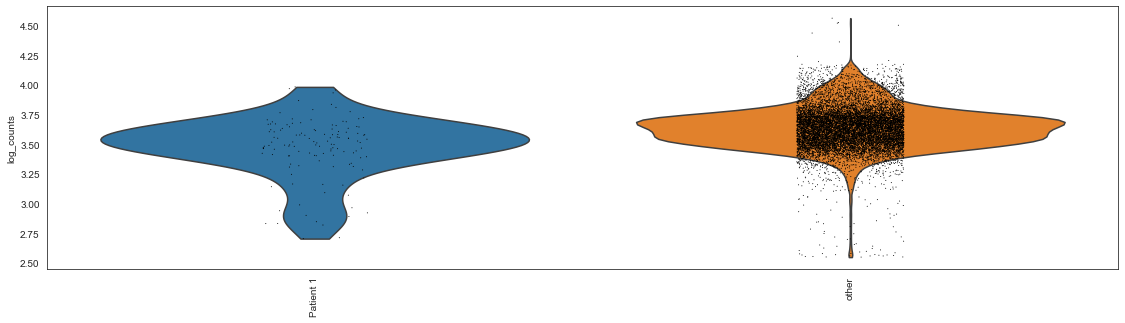

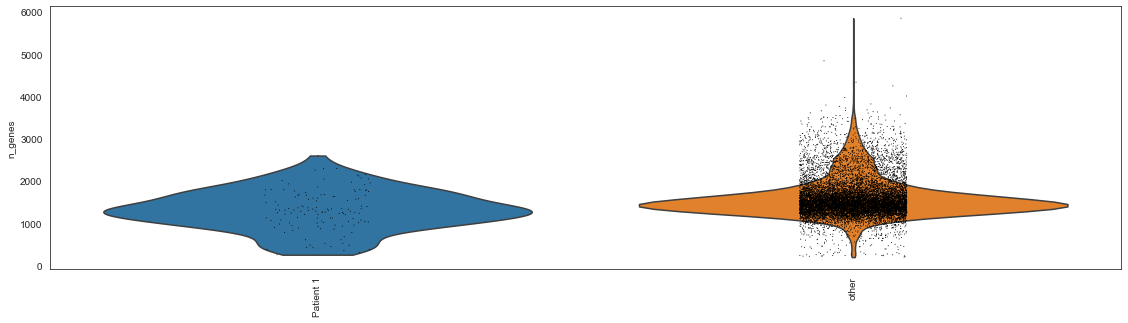

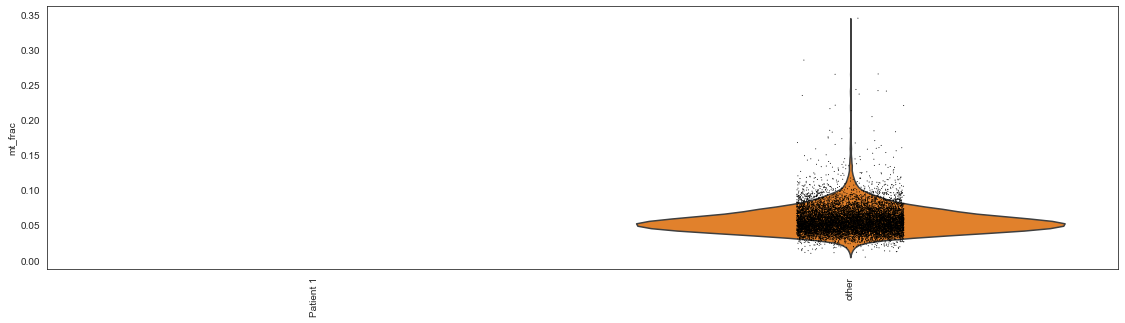

In [6]:
rcParams['figure.figsize'] = (15, 5)
sc.pl.violin(adata, ['log_counts'], groupby='patient', size=1, log=False, rotation=90)
sc.pl.violin(adata, ['n_genes'], groupby='patient', size=1, log=False, rotation=90)
sc.pl.violin(adata, ['mt_frac'], groupby='patient', size=1, log=False, rotation=90)

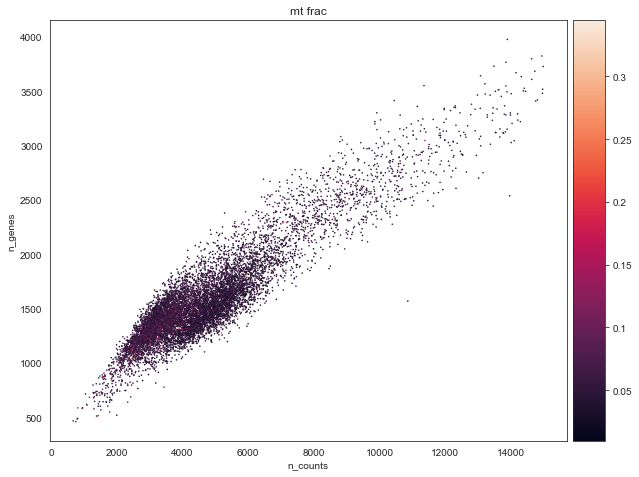

In [7]:
rcParams['figure.figsize'] = (8, 8)
sc.pl.scatter(adata, y='n_genes', x='n_counts', color='mt_frac', size=10, show=False)

In [8]:
adata.obs['batch'].value_counts()

nan             11277
Macrogen          901
CoreFacility      325
Name: batch, dtype: int64

In [9]:
print(f'number of cells: {len(adata)}')
adata = adata[adata.obs['mt_frac'] < 0.2]
print(f'number of cells after mt filter: {len(adata)}')

number of cells: 12503
number of cells after mt filter: 11263


C:\Users\felix.drost\Anaconda3\envs\scanpy\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


All cells from Macrogen and CoreFacility in obs 'batch' get filtered out by this.

In [10]:
print(f'number of cells: {len(adata)}')
adata = adata[adata.obs['n_counts'] > 1000]
print(f'number of cells after low count filter: {len(adata)}')
adata = adata[adata.obs['n_counts'] < 8000]
print(f'number of cells after high count filter: {len(adata)}')

number of cells: 11263
number of cells after low count filter: 11256
number of cells after high count filter: 10472


C:\Users\felix.drost\Anaconda3\envs\scanpy\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
C:\Users\felix.drost\Anaconda3\envs\scanpy\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [11]:
print(f'number of cells: {len(adata)}')
adata = adata[adata.obs['n_genes'] > 500]
print(f'number of cells low gene filter: {len(adata)}')

number of cells: 10472
number of cells low gene filter: 10472


C:\Users\felix.drost\Anaconda3\envs\scanpy\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [12]:
print(f'number of genes: {len(adata.var)}')
sc.pp.filter_genes(adata, min_cells=10)
print(f'number of genes after seldom gene filter: {len(adata.var)}')

number of genes: 16598


Trying to set attribute `.var` of view, copying.
C:\Users\felix.drost\Anaconda3\envs\scanpy\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


number of genes after seldom gene filter: 12062


In [13]:
adata.obs['batch'].unique()

['nan']
Categories (1, object): ['nan']

## Doublet detection with scrublet

In [14]:
import scrublet as scr
import scipy.io
import time
import seaborn as sb

In [15]:
adata.obs['doublet_score'] = np.zeros(adata.shape[0])
adata.obs['doublet'] = np.zeros(adata.shape[0])

In [16]:
# filtering / preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters
expected_doublet_rate = 0.02
sim_doublet_ratio = 3
n_neighbors = 15


t0 = time.time()
scrub = scr.Scrublet(counts_matrix = adata.X,
                    n_neighbors = n_neighbors,
                    sim_doublet_ratio = sim_doublet_ratio,
                    expected_doublet_rate = expected_doublet_rate)
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts = min_counts,
                                                          min_cells = min_cells,
                                                          n_prin_comps = n_pc,
                                                          use_approx_neighbors = True,
                                                          get_doublet_neighbor_parents = False)
adata.obs['doublet_score'] = doublet_scores
adata.obs['doublet'] = predicted_doublets
t1 = time.time()
print('Elapsed time: {:.1f} seconds'.format(t1-t0))

Preprocessing...


C:\Users\felix.drost\Anaconda3\envs\scanpy\lib\site-packages\scrublet\helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
C:\Users\felix.drost\Anaconda3\envs\scanpy\lib\site-packages\scrublet\helper_functions.py:251: RuntimeWarning: invalid value encountered in sqrt
  CV_eff = np.sqrt((1+a)*(1+b) - 1);
C:\Users\felix.drost\Anaconda3\envs\scanpy\lib\site-packages\scrublet\helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 3.3%
Estimated detectable doublet fraction = 48.6%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 6.8%
Elapsed time: 7.6 seconds
Elapsed time: 7.9 seconds


<AxesSubplot:xlabel='doublet_score'>

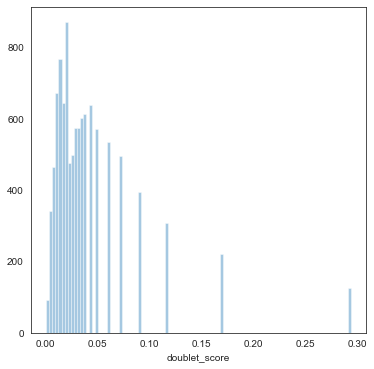

In [19]:
rcParams['figure.figsize'] = (6, 6)
sb.distplot(adata.obs['doublet_score'], bins=100, kde=False)

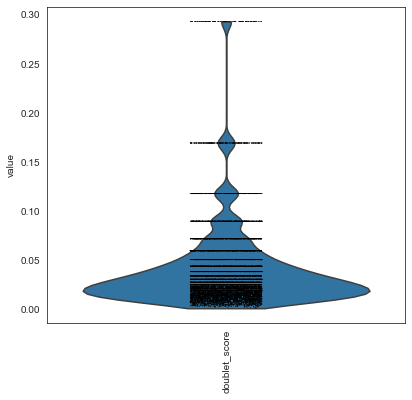

In [20]:
sc.pl.violin(adata, ['doublet_score'], size=1, log=False, rotation=90)

In [21]:
thr = 0.08
idx_filter = adata.obs['doublet_score'] <= thr

print(f'number of cells: {len(adata)}')
adata = adata[idx_filter].copy()
print(f'Number of cells after double filter: {adata.n_obs}')

number of cells: 10472
Number of cells after double filter: 9423


C:\Users\felix.drost\Anaconda3\envs\scanpy\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


QC after filtering

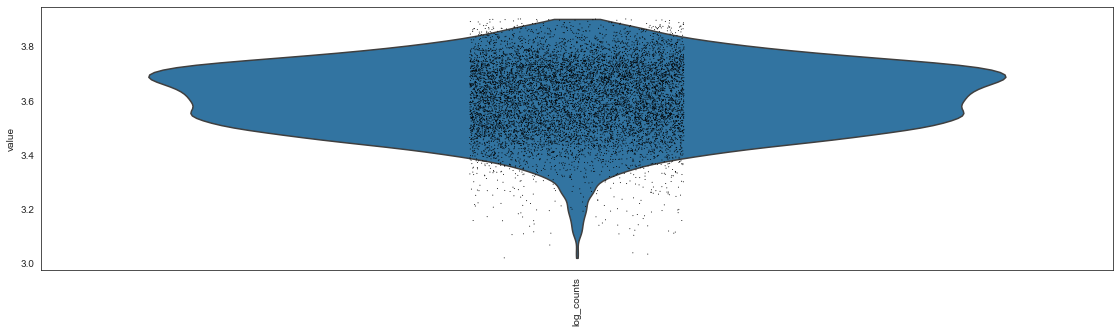

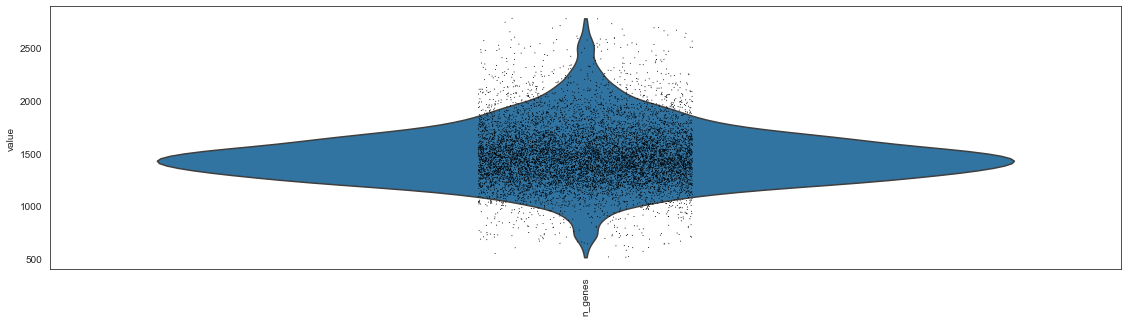

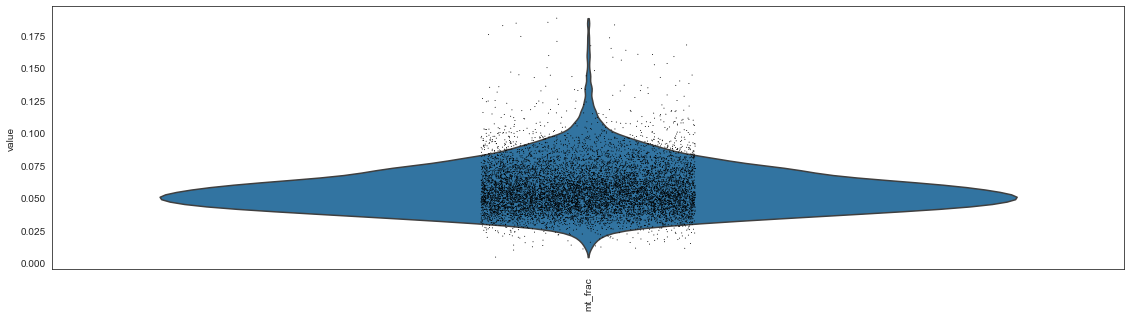

In [23]:
rcParams['figure.figsize'] = (15, 5)
sc.pl.violin(adata, ['log_counts'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['n_genes'], size=1, log=False, rotation=90)
sc.pl.violin(adata, ['mt_frac'], size=1, log=False, rotation=90)

In [24]:
sc.write(adata=adata, filename=path_filtered)

## Filter cells with productive single IR 

In [25]:
adata = sc.read_h5ad(path_raw)

In [26]:
print(f'Number of cells: {adata.n_obs}')
adata = adata[adata.obs['has_tcr']=='True']
print(f'Number of cells with IR: {adata.n_obs}')

Number of cells: 12503
Number of cells with IR: 11277


C:\Users\felix.drost\Anaconda3\envs\scanpy\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [27]:
print(f'Number of cells: {adata.n_obs}')
adata = adata[adata.obs['multi_chain']=='False']

print(f'Number of cells without >2 chains: {adata.n_obs}')

adata = adata[adata.obs['TRA_2_cdr3']=='None']
adata = adata[adata.obs['TRB_2_cdr3']=='None']

print(f'Number of cells with =1 per chain: {adata.n_obs}')

Number of cells: 11277
Number of cells without >2 chains: 11147
Number of cells with =1 per chain: 9853


## Filter unpaired Sequences

In [28]:
print(f'Number of cells: {adata.n_obs}')
adata = adata[adata.obs['TRB_1_cdr3'] != 'None']
print(f'Number of cells with beta chain: {adata.n_obs}')

Number of cells: 9853
Number of cells with beta chain: 9521


In [29]:
print(f'Number of cells: {adata.n_obs}')
adata = adata[adata.obs['TRA_1_cdr3'] != 'None']
print(f'Number of cells with alpha chain: {adata.n_obs}')

Number of cells: 9521
Number of cells with alpha chain: 6713


Sanity check: only a single CDR3alpha and CDR3beta chain is present

In [30]:
def check_invalids(sequence):
    allowed_letters = 'GALMFWKQESPVICYHRNDT'
    for letter in sequence:
        if letter not in allowed_letters:
            return False
    return True

for seq_alpha in adata.obs['TRA_1_cdr3']:
    if not check_invalids(seq_alpha):
        print(seq_alpha)
for seq_beta in adata.obs['TRB_1_cdr3']:
    if not check_invalids(seq_beta):
        print(seq_beta)

## Clonotype Annotation

In [31]:
adata.obs['TRA+TRB'] = adata.obs['TRA_1_cdr3'].astype(str) + '+' + adata.obs['TRB_1_cdr3'].astype(str)
clono_dict = {clone: idx for idx, clone in enumerate(adata.obs['TRA+TRB'].unique())}
adata.obs['clonotype'] = adata.obs['TRA+TRB'].map(clono_dict)
print(len(adata.obs['clonotype'].unique()))
adata.obs['clonotype'].value_counts()

Trying to set attribute `.obs` of view, copying.


4102


6       531
12      182
9       158
46      114
31      106
       ... 
2824      1
777       1
2828      1
781       1
2047      1
Name: clonotype, Length: 4102, dtype: int64

## Embed TR

Append both chains, add start ('<'), stop ('>') and seperator ('+') token. For training purpose IR data might be needed as one hot vector.

In [32]:
import sys
sys.path.append('../')
import tcr_embedding as tcr

In [33]:
adata.obs['TRA+TRB'] = adata.obs['TRA_1_cdr3'].astype(str) + '+' + adata.obs['TRB_1_cdr3'].astype(str)
pad = adata.obs['TRA+TRB'].str.len().max()
pad = int(pad)
pad

39

In [34]:
aa_to_id = {'_': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13,
            'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '+': 21, '<': 22, '>': 23}
tcr.utils.aa_encoding(adata, read_col='TRA+TRB', ohe_col='one_hot', label_col='tcr_seq', length_col='seq_len', pad=pad, aa_to_id=aa_to_id, start_end_symbol=True)


In [35]:
print(adata.obsm['tcr_seq'].shape)
print(adata.obsm['one_hot'].shape)
print(adata.uns['aa_to_id'])

(6713, 41)
(6713, 41, 24)
{'_': 0, 'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, '+': 21, '<': 22, '>': 23}


In [36]:
max_length_alpha = adata.obs['TRA_1_cdr3'].str.len().max()
max_length_beta = adata.obs['TRB_1_cdr3'].str.len().max()
max_length = max(max_length_alpha, max_length_beta)

In [37]:
aa_to_id = adata.uns['aa_to_id']
tcr.utils.aa_encoding(adata, read_col='TRA_1_cdr3', label_col='alpha_seq', length_col='alpha_len', pad=max_length, aa_to_id=aa_to_id, start_end_symbol=False)
tcr.utils.aa_encoding(adata, read_col='TRB_1_cdr3', label_col='beta_seq', length_col='beta_len', pad=max_length, aa_to_id=aa_to_id, start_end_symbol=False)

In [38]:
print(max_length_alpha)
print(max_length_beta)

20
23


## Train-Val-Test Split

In [39]:
adata.obs['identifier+condition'] = adata.obs['identifier'].astype(str) + '_' + adata.obs['condition'].astype(str)
adata.obs['identifier+condition'].sample(10)

Sample_20063a010_01_GAAACTCCAGCTCGAC      Sample_20063a010_01_stimulated
Sample_20063a009_01_TCTGGAAGTCGAGATG    Sample_20063a009_01_unstimulated
Sample_20063a010_01_TGTTCCGGTTACGGAG      Sample_20063a010_01_stimulated
Sample_20063a009_01_ACATCAGTCCCAAGAT    Sample_20063a009_01_unstimulated
Sample_20063a010_01_CCAGCGATCGCGCCAA      Sample_20063a010_01_stimulated
Sample_20063a010_01_CAGCATACATCGGGTC      Sample_20063a010_01_stimulated
Sample_20063a009_01_GAATGAATCACTTCAT    Sample_20063a009_01_unstimulated
Sample_20063a009_01_AGTCTTTGTAGGGTAC    Sample_20063a009_01_unstimulated
Sample_20063a009_01_CTGATAGAGGCAGGTT    Sample_20063a009_01_unstimulated
Sample_20063a009_01_ATTCTACCACAGCCCA    Sample_20063a009_01_unstimulated
Name: identifier+condition, dtype: object

In [40]:
random_seed = 15
# Create Train-Val and Test set
train_val, test = tcr.utils.stratified_group_shuffle_split(adata.obs, stratify_col='identifier+condition', group_col='clonotype', val_split=0.15, random_seed=random_seed)
# Split Train-Val into Train and Val set
train, val = tcr.utils.stratified_group_shuffle_split(train_val, stratify_col='identifier+condition', group_col='clonotype', val_split=0.15, random_seed=random_seed)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 36.71it/s]


In [41]:
print('Train Samples: ', len(train))
print('Train Ratio: ', len(train) / len(adata.obs))
print('Val Samples: ', len(val))
print('Val Ratio: ', len(val) / len(adata.obs))
print('Test Samples: ', len(test))
print('Test Ratio: ', len(test) / len(adata.obs))

Train Samples:  5343
Train Ratio:  0.7959183673469388
Val Samples:  680
Val Ratio:  0.10129599284969462
Test Samples:  690
Test Ratio:  0.10278563980336661


### Visualize Distribution

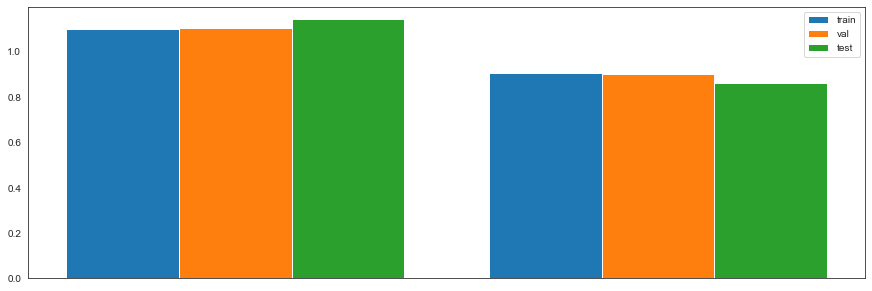

In [42]:
pl.figure(figsize=(15,5))
pl.hist([train['identifier'], val['identifier'], test['identifier']], density=True, bins=len(train['identifier'].unique()), label=['train', 'val', 'test'])
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

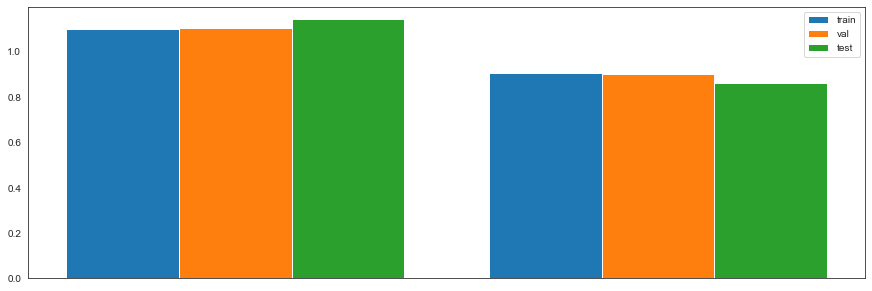

In [43]:
pl.figure(figsize=(15,5))
pl.hist([train['condition'], val['condition'], test['condition']], density=True, bins=len(train['condition'].unique()), label=['train', 'val', 'test'])
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

In [44]:
adata.obs.loc[train.index, 'set'] = 'train'
adata.obs.loc[val.index, 'set'] = 'val'
adata.obs.loc[test.index, 'set'] = 'test'
adata.obs['set'].value_counts()

train    5343
test      690
val       680
Name: set, dtype: int64

In [45]:
adata.write_h5ad(path_tcr_split, compression='gzip')

... storing 'TRA+TRB' as categorical
... storing 'one_hot' as categorical
... storing 'tcr_seq' as categorical
... storing 'alpha_seq' as categorical
... storing 'beta_seq' as categorical
... storing 'identifier+condition' as categorical
... storing 'set' as categorical


## Highly Variable Genes

In [46]:
adata = sc.read_h5ad(path_tcr_split)

In [47]:
sc.pp.highly_variable_genes(adata, n_top_genes=5000, batch_key='identifier')
print('Shape before: ', adata.shape)
adata = adata[:, adata.var['highly_variable']]
print('Shape after: ', adata.shape)

Shape before:  (6713, 16598)
Shape after:  (6713, 5000)


In [48]:
sc.write(adata=adata, filename=path_highlyvar)

# Analysis

### UMAPS

In [49]:
adata = sc.read_h5ad(path_highlyvar)

In [50]:
len(adata)

6713

In [46]:
def add_combination(adata, obs_1, obs_2):
    obs_joint = [x + '+' + y for x, y in zip(adata.obs[obs_1], adata.obs[obs_2])]
    adata.obs[obs_1 + '+' + obs_2] = obs_joint

In [47]:
adata.obsm.pop('X_umap')
adata.uns.pop('neighbors')

OverloadedDict, wrapping:
	{'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'method': 'umap', 'metric': 'euclidean', 'n_neighbors': 15, 'n_pcs': 30}, 'rp_forest': {'children': {'data': array([[    1,  1994],
       [    2,  1863],
       [    3,  1548],
       ...,
       [-1535,    -1],
       [-1536,    -1],
       [-1537,    -1]], dtype=int64), 'start': array([    0,  3057,  6178,  9297, 12306, 15359, 18378, 21465, 24494,
       27615, 30664], dtype=int64)}, 'hyperplanes': {'data': array([[-2.9930186 , -0.07961357,  0.95594794, ..., -0.04813108,
         0.09111884,  0.02881885],
       [-0.3168344 , -0.25923485, -1.0162697 , ...,  0.15491018,
         0.13611928, -0.18597232],
       [-1.3559153 , -0.6444096 ,  0.7797755 , ..., -0.08202893,
        -0.03465878, -0.2898142 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,


start umaping


... storing 'identifier+condition' as categorical
... storing 'identifier+T_cells' as categorical
... storing 'condition+T_cells' as categorical


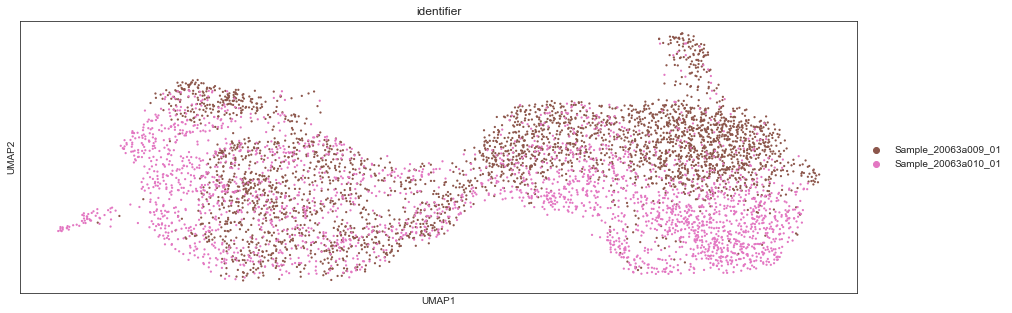

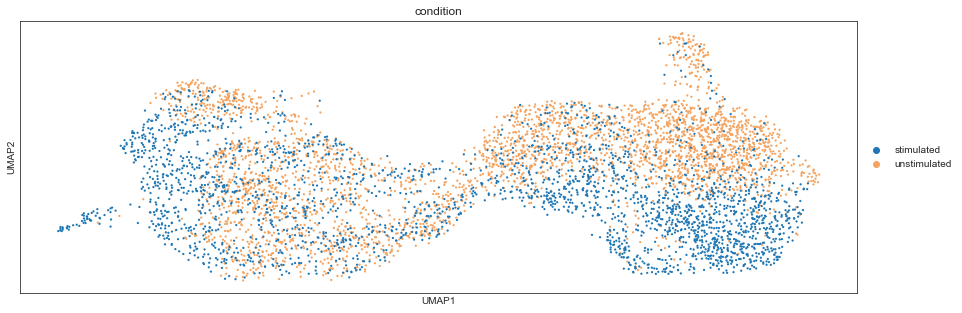

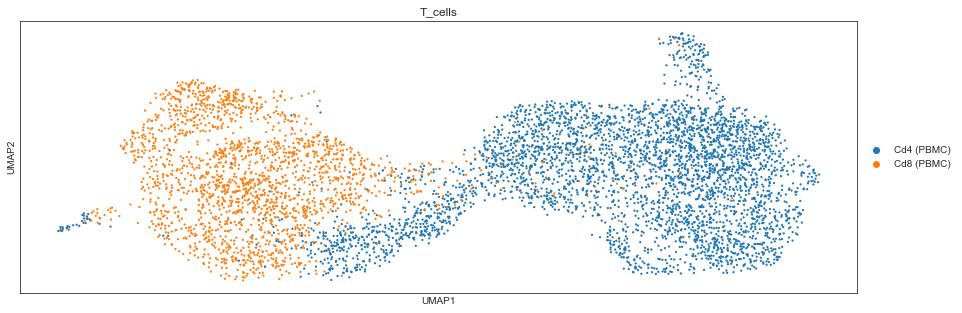

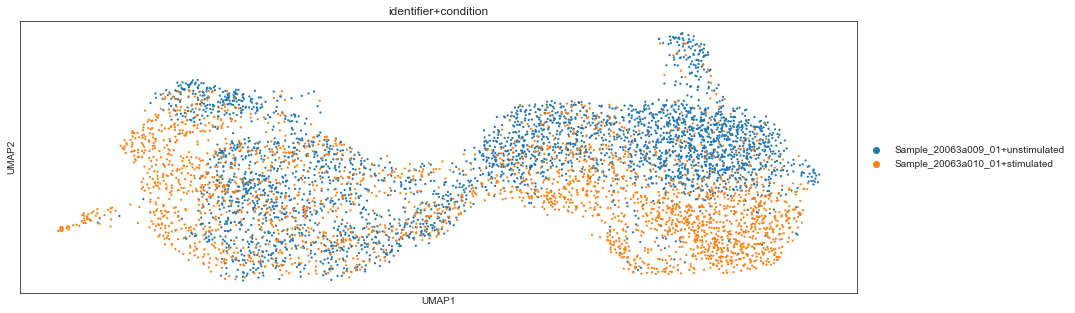

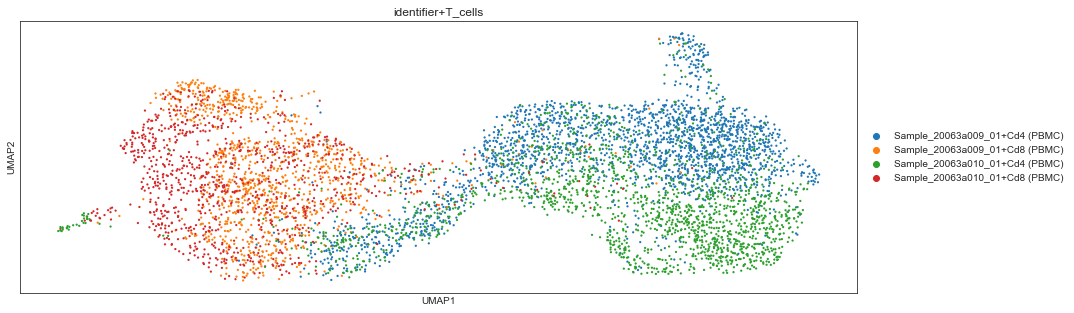

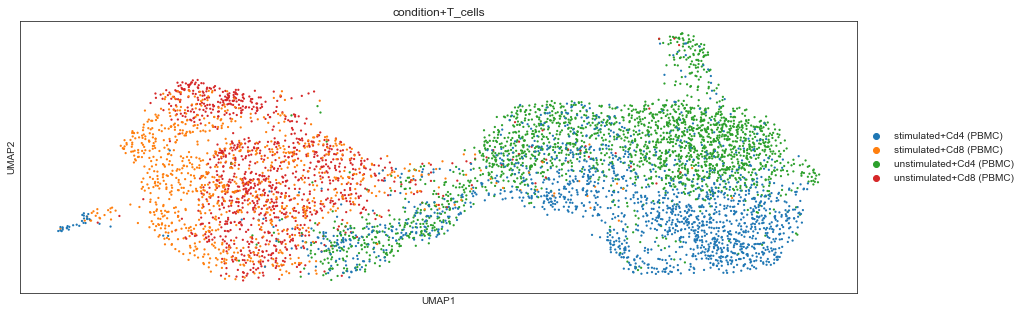

In [48]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

add_combination(adata, 'identifier', 'condition')
add_combination(adata, 'identifier', 'T_cells')
add_combination(adata, 'condition', 'T_cells')

groups = ['identifier', 'condition', 'T_cells', 
          'identifier+condition', 'identifier+T_cells', 'condition+T_cells']

print('start umaping')
adata.obsm.pop('X_umap')
adata.uns.pop('neighbors')

sc.pp.neighbors(adata)
sc.tl.umap(adata)

for col in groups:
    sc.pl.umap(adata, color=col)

In [5]:
for el in adata.obs.columns:
    print(el)

batch
grouping
name
identifier
n_counts
n_genes
percent.mito
QC_group
size_factors
S_score
G2M_score
phase
louvain
cell_type
dcluster
multi_chain
TRA_1_cdr3
TRA_2_cdr3
TRB_1_cdr3
TRB_2_cdr3
TRA_1_junction_ins
TRA_2_junction_ins
TRB_1_junction_ins
TRB_2_junction_ins
TRA_1_expr
TRA_2_expr
TRB_1_expr
TRB_2_expr
TRA_1_v_gene
TRA_2_v_gene
TRB_1_v_gene
TRB_2_v_gene
TRA_1_d_gene
TRA_2_d_gene
TRB_1_d_gene
TRB_2_d_gene
TRA_1_j_gene
TRA_2_j_gene
TRB_1_j_gene
TRB_2_j_gene
TRA_1_c_gene
TRA_2_c_gene
TRB_1_c_gene
TRB_2_c_gene
TRA_1_cdr3_nt
TRA_2_cdr3_nt
TRB_1_cdr3_nt
TRB_2_cdr3_nt
has_tcr
sample_rna
sample_tcr
clonotype_cellranger
concatenation
patient
condition
mt_frac
CD3_all_genes
leiden
chain_pairing
leiden_corrected
CD8_all_genes
CD4_states
CD8_states
tcr_signalling_score
ifn response_score
proliferation_score
cd8 cytotoxic_score
cd8 cytokine_score
ifng_pos_cluster
clonotype
clonotype_size
ct_cluster_aa_alignment
ct_cluster_aa_alignment_size
ct_cluster_aa_alignment_same_v
ct_cluster_aa_alignmen

In [47]:
adata.obs['reactive_combined'].value_counts()

un-reactive (unstimulated)     3466
un-reactive (stimulated)       2815
CD8 reactive (unstimulated)     152
CD8 reactive (stimulated)       144
CD4 reactive (unstimulated)      85
CD4 reactive (stimulated)        51
Name: reactive_combined, dtype: int64

In [48]:
adata.obs['batch'].value_counts()

nan    6713
Name: batch, dtype: int64

In [51]:
adata.obs['patient'].value_counts()

other    6713
Name: patient, dtype: int64

## Lost cells per filtering step

In [52]:
cells_per_step = {
    'raw':  12503,
    'mt_frac': 11263,
    'low_count': 11256,
    'high_count': 10472,
    'low genes': 10472,
    'doublet': 9423,
    '>2 chains': 9413,
    '<=1 TR': 8856,
    'has_TRB': 8548,
    'has_TRA': 5999
}

[Text(0, 0, 'raw'),
 Text(1, 0, 'mt_frac'),
 Text(2, 0, 'low_count'),
 Text(3, 0, 'high_count'),
 Text(4, 0, 'low genes'),
 Text(5, 0, 'doublet'),
 Text(6, 0, '>2 chains'),
 Text(7, 0, '<=1 TR'),
 Text(8, 0, 'has_TRB'),
 Text(9, 0, 'has_TRA')]

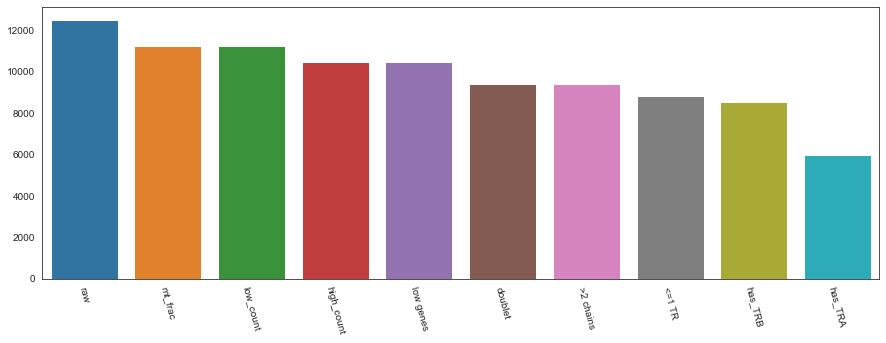

In [53]:
keys = list(cells_per_step.keys())
# get values in the same order as keys, and parse percentage values
vals = [float(cells_per_step[k]) for k in keys]
plot_filter = sb.barplot(x=keys, y=vals)
plot_filter.set_xticklabels(keys, rotation=-75)